In [23]:
import tensorflow as tf
import numpy as np
import pandas as pd
from numpy import genfromtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from collections import deque
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint, EarlyStopping



(600000, 3)
x_0    5500
x_1    5500
x_2    5500
dtype: int64


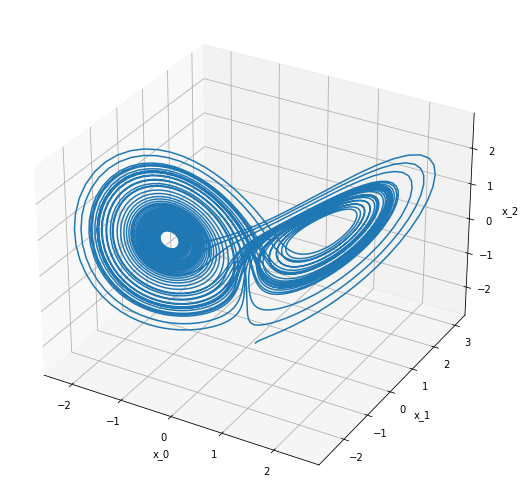

In [24]:
# ## Read the raw data

data = pd.read_csv('normalized_lorenz_0.01.csv')
print(data.shape)
data.head()


fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111, projection = '3d')

plot_data = data.iloc[:5500]

print(plot_data.count())
plot_data.head()
x = plot_data['x_0']
y = plot_data['x_1']
z = plot_data['x_2']

ax.set_xlabel("x_0")
ax.set_ylabel("x_1")
ax.set_zlabel("x_2")

ax.plot(x, y, z)

plt.show()


In [25]:
# ## Prepare train, validation and test sets for LSTMS
# - train is 500K (first 500K samples)
# - val is 10K (next 10K)
# - test  is 2K (next 2K)
# training size parameters
train_size = 5000
val_size = 5000
test_size = 2000


In [26]:
# lookback

lookback = 3

def make_LSTM_datasets(data,traian_size,val_size,test_size):
    samples = train_size + val_size + test_size
    nfeatures = data.shape[1]
    sdata = np.transpose(data.values)[:,:samples]

    Xtemp = {}
    for i in range(lookback):    
        Xtemp[i] = sdata[:,i:samples-(lookback-i-1)]

    X = Xtemp[0]
    for i in range(lookback-1):
        X = np.vstack([X,Xtemp[i+1]])

    X = np.transpose(X)
    Y = np.transpose(sdata[:,lookback:samples])

    Xtrain = X[:train_size,:]
    Ytrain = Y[:train_size,:]

    Xval = X[train_size:train_size+val_size,:]
    Yval = Y[train_size:train_size+val_size,:]

    Xtest = X[train_size+val_size:,:]
    Ytest = Y[train_size+val_size:,:]

    # reshape inputs to be 3D [samples, timesteps, features] for LSTM

    Xtrain = Xtrain.reshape((Xtrain.shape[0], lookback, nfeatures))
    Xval = Xval.reshape((Xval.shape[0], lookback,nfeatures))
    Xtest = Xtest.reshape((Xtest.shape[0], lookback,nfeatures))
    print("Xtrain shape = ", Xtrain.shape, "Ytrain shape = ", Ytrain.shape)
    print("Xval shape =   ", Xval.shape, "  Yval shape =   ", Yval.shape)
    print("Xtest shape =  ", Xtest.shape, " Ytest shape =  ", Ytest.shape)
    
    return Xtrain,Ytrain,Xval,Yval,Xtest,Ytest,nfeatures

In [34]:
# ## Setup and train the LSTM
# design network

# LSTM parameters
nhidden = 30

def make_and_train_LSTM_model(Xtrain,Ytrain,nfeatures,nhidden):
    model = Sequential()
    model.add(LSTM(nhidden, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    model.add(Dense(nfeatures))
    model.compile(
        loss = "mean_squared_error",  
        optimizer = 'adam',
        metrics=['mae', 'mape'])
    
    # fit network
    history = model.fit(Xtrain, Ytrain, epochs=10, batch_size=72, verbose=2, shuffle=True, callbacks=[callback])
    
    return model,history


In [35]:
# test model on set aside test set (actually validation set)

def model_predict(model,Xval):
    ypred = np.zeros((Xval.shape[0],nfeatures))
    print(Xval.shape[0])
    for i in range(Xval.shape[0]):
        if (i % 200) == 0:
            print(i)
        if i ==0:
            tt = Xval[0,:,:].reshape((1,lookback,nfeatures))
            ypred[i,:] = model.predict(tt) 
        elif i < lookback:
            tt = Xval[i,:,:].reshape((1,lookback,nfeatures))
            u = ypred[:i,:]
            tt[0,(lookback-i):lookback,:] = u
            ypred[i,:] = model.predict(tt)
        else:
            tt = ypred[i-lookback:i,:].reshape((1,lookback,nfeatures))
            ypred[i,:] = model.predict(tt)
    return ypred


In [36]:


callback = EarlyStopping(monitor='val_loss',
                         patience=4,
                         restore_best_weights=True)


In [37]:
# ## Run everything

Xtrain,Ytrain,Xval,Yval,Xtest,Ytest,nfeatures = make_LSTM_datasets(data,train_size,val_size,test_size)
model,history = make_and_train_LSTM_model(Xtrain,Ytrain,nfeatures,nhidden)
ypred = model_predict(model,Xval)
#np.savetxt('ypred.csv',ypred,delimiter=',')     
#np.savetxt('ytest.csv',Yval,delimiter=',')



Xtrain shape =  (5000, 3, 3) Ytrain shape =  (5000, 3)
Xval shape =    (5000, 3, 3)   Yval shape =    (5000, 3)
Xtest shape =   (1998, 3, 3)  Ytest shape =   (1997, 3)
Epoch 1/10


2022-01-26 15:58:17.041279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-26 15:58:17.230307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-26 15:58:17.330544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


70/70 - 1s - loss: 0.5371 - mae: 0.5684 - mape: 215.0950 - 1s/epoch - 18ms/step
Epoch 2/10
70/70 - 0s - loss: 0.0654 - mae: 0.1710 - mape: 118.8313 - 496ms/epoch - 7ms/step
Epoch 3/10
70/70 - 0s - loss: 0.0206 - mae: 0.0965 - mape: 75.6207 - 491ms/epoch - 7ms/step
Epoch 4/10
70/70 - 1s - loss: 0.0113 - mae: 0.0716 - mape: 52.3771 - 506ms/epoch - 7ms/step
Epoch 5/10
70/70 - 0s - loss: 0.0068 - mae: 0.0544 - mape: 31.4559 - 488ms/epoch - 7ms/step
Epoch 6/10
70/70 - 0s - loss: 0.0047 - mae: 0.0437 - mape: 24.2800 - 474ms/epoch - 7ms/step
Epoch 7/10
70/70 - 1s - loss: 0.0035 - mae: 0.0372 - mape: 20.1096 - 503ms/epoch - 7ms/step
Epoch 8/10
70/70 - 0s - loss: 0.0028 - mae: 0.0331 - mape: 19.2381 - 484ms/epoch - 7ms/step
Epoch 9/10
70/70 - 0s - loss: 0.0023 - mae: 0.0297 - mape: 18.2330 - 474ms/epoch - 7ms/step
Epoch 10/10
70/70 - 0s - loss: 0.0019 - mae: 0.0275 - mape: 17.7740 - 466ms/epoch - 7ms/step
5000
0


2022-01-26 15:58:22.444954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-26 15:58:22.480113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800


In [50]:
ypred

(5000, 3)

In [42]:
np.savetxt('output.csv',ypred,delimiter=",")
predicted_data = pd.read_csv('output.csv',
                            names=["x_0", "x_1", "x_2"])
print(predicted_data)

           x_0       x_1       x_2
0     1.520344  0.439645  1.745294
1     1.424735  0.302207  1.664459
2     1.326559  0.188518  1.570239
3     1.227300  0.094033  1.468253
4     1.131384  0.013911  1.368844
...        ...       ...       ...
4995 -0.094309  0.028048 -0.036837
4996 -0.072920  0.017162 -0.115514
4997 -0.057090  0.006994 -0.193138
4998 -0.045978 -0.002452 -0.269889
4999 -0.038781 -0.011235 -0.345870

[5000 rows x 3 columns]


In [47]:
print(predicted_data)

           x_0       x_1       x_2
0     1.520344  0.439645  1.745294
1     1.424735  0.302207  1.664459
2     1.326559  0.188518  1.570239
3     1.227300  0.094033  1.468253
4     1.131384  0.013911  1.368844
...        ...       ...       ...
4995 -0.094309  0.028048 -0.036837
4996 -0.072920  0.017162 -0.115514
4997 -0.057090  0.006994 -0.193138
4998 -0.045978 -0.002452 -0.269889
4999 -0.038781 -0.011235 -0.345870

[5000 rows x 3 columns]


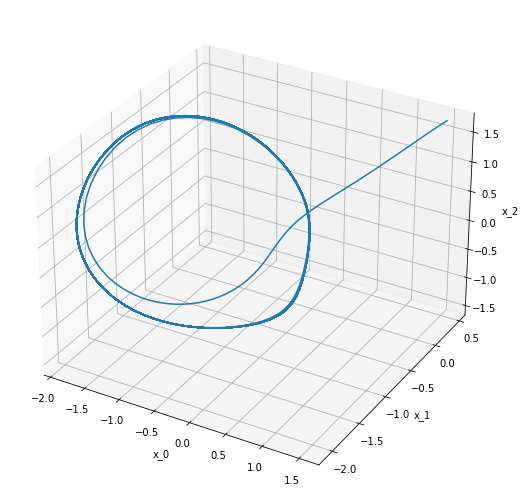

In [51]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111, projection = '3d')
#data = predicted_data.iloc[:1500]

#print(df.count())
x = predicted_data['x_0']
y = predicted_data['x_1']
z = predicted_data['x_2']

ax.set_xlabel("x_0")
ax.set_ylabel("x_1")
ax.set_zlabel("x_2")

ax.plot(ypred[:,0],ypred[:,1],ypred[:,2])
#ax.view_init(-130, 0)

plt.show()


TypeError: 'function' object is not subscriptable

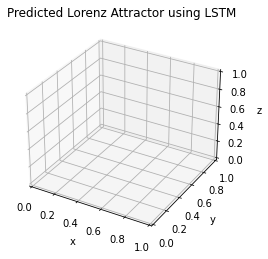

In [45]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('Predicted Lorenz Attractor using LSTM')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.plot(model_predict[:,0],model_predict[:,1],model_predict[:,2])
plt.show()


In [12]:
import datetime

import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns
import pandas as pd


In [21]:
DATASET_PATH = 'normalized_lorenz_0.01.csv'
my_data = pd.read_csv(DATASET_PATH)
BATCH_SIZE = 8
NUM_WORKERS = 0
LR = 2e-4
EPOCHS = 30

# Model parameters
d_model = 64 # Lattent dim
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
attention_size = 12 # Attention window size
dropout = 0.2 # Dropout rate
pe = None # Positional encoding
chunk_mode = None

d_input = 27 # From dataset
d_output = 8 # From dataset

# Config
sns.set()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
my_data.head()

Using device cpu


,x_0,x_1,x_2
0,0.131448,0.115472,-2.721660
1,0.133095,0.145388,-2.720358
2,0.137846,0.175781,-2.718737
3,0.145498,0.207373,-2.716736
4,0.155943,0.240839,-2.714263


In [22]:
train_size = 5000
val_size = 5000
test_size = 2000

In [29]:
# Load transformer with Adam optimizer and MSE loss function
net = nn.Transformer(d_input, d_model, d_output, q, v, h, N).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = OZELoss(alpha=0.3)

AssertionError: embed_dim must be divisible by num_heads